In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import statsmodels.graphics.tsaplots as tsa
from statsmodels.tsa.seasonal import seasonal_decompose
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import pywt
import datetime
from keras.layers import Dropout

In [2]:
hdfc_data = pd.read_csv('HDFC.daily.csv')
hdfc_data.head()

,symbol,t,o,h,l,c,v
0,HDFC,983232000,57.40,59.7,57.40,59.13,1927790
1,HDFC,983318400,59.70,62.1,58.68,59.35,7308190
2,HDFC,983404800,60.48,60.9,58.61,59.85,3468220
3,HDFC,983491200,60.50,60.8,55.30,55.61,2408840
4,HDFC,983750400,55.51,57.4,51.64,52.62,2452810


In [3]:
type(hdfc_data['symbol'].unique().tolist()[0])

str

In [4]:
hdfc_data.shape

(4973, 7)

Converting **`'t'`** column from timestamp to actual date

In [5]:
hdfc_data['datetime'] = hdfc_data['t'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [6]:
hdfc_data.head()

,symbol,t,o,h,l,c,v,datetime
0,HDFC,983232000,57.40,59.7,57.40,59.13,1927790,2001-02-27 05:30:00
1,HDFC,983318400,59.70,62.1,58.68,59.35,7308190,2001-02-28 05:30:00
2,HDFC,983404800,60.48,60.9,58.61,59.85,3468220,2001-03-01 05:30:00
3,HDFC,983491200,60.50,60.8,55.30,55.61,2408840,2001-03-02 05:30:00
4,HDFC,983750400,55.51,57.4,51.64,52.62,2452810,2001-03-05 05:30:00


In [7]:
hdfc_data = hdfc_data.loc[:,['symbol','o','h','l','c','datetime']].rename(columns = {'o':'open','h':'high','l':'low','c':'close'})
hdfc_data.head()

,symbol,open,high,low,close,datetime
0,HDFC,57.40,59.7,57.40,59.13,2001-02-27 05:30:00
1,HDFC,59.70,62.1,58.68,59.35,2001-02-28 05:30:00
2,HDFC,60.48,60.9,58.61,59.85,2001-03-01 05:30:00
3,HDFC,60.50,60.8,55.30,55.61,2001-03-02 05:30:00
4,HDFC,55.51,57.4,51.64,52.62,2001-03-05 05:30:00


In [8]:
print('Unique Dates we have: ',hdfc_data.datetime.nunique())
print('HDFC INFO:')
print(hdfc_data.info())

Unique Dates we have:  4973
HDFC INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4973 entries, 0 to 4972
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   symbol    4973 non-null   object 
 1   open      4973 non-null   float64
 2   high      4973 non-null   float64
 3   low       4973 non-null   float64
 4   close     4973 non-null   float64
 5   datetime  4973 non-null   object 
dtypes: float64(4), object(2)
memory usage: 233.2+ KB
None


In [9]:
hdfc_data['datetime'] = pd.to_datetime(hdfc_data['datetime'])
hdfc_data['time'] = hdfc_data['datetime'].dt.strftime('%H:%M:%S')
hdfc_data['date'] = pd.to_datetime(hdfc_data['datetime'].dt.date) 

In [10]:
hdfc_data.head()

,symbol,open,high,low,close,datetime,time,date
0,HDFC,57.40,59.7,57.40,59.13,2001-02-27 05:30:00,05:30:00,2001-02-27
1,HDFC,59.70,62.1,58.68,59.35,2001-02-28 05:30:00,05:30:00,2001-02-28
2,HDFC,60.48,60.9,58.61,59.85,2001-03-01 05:30:00,05:30:00,2001-03-01
3,HDFC,60.50,60.8,55.30,55.61,2001-03-02 05:30:00,05:30:00,2001-03-02
4,HDFC,55.51,57.4,51.64,52.62,2001-03-05 05:30:00,05:30:00,2001-03-05


In [11]:
hdfc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4973 entries, 0 to 4972
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   symbol    4973 non-null   object        
 1   open      4973 non-null   float64       
 2   high      4973 non-null   float64       
 3   low       4973 non-null   float64       
 4   close     4973 non-null   float64       
 5   datetime  4973 non-null   datetime64[ns]
 6   time      4973 non-null   object        
 7   date      4973 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(4), object(2)
memory usage: 310.9+ KB


In [12]:
for i in hdfc_data.columns.to_list():
    print('Column: ',i)
    print('Unique Values:',hdfc_data[i].nunique())

Column:  symbol
Unique Values: 1
Column:  open
Unique Values: 3737
Column:  high
Unique Values: 4054
Column:  low
Unique Values: 4241
Column:  close
Unique Values: 4717
Column:  datetime
Unique Values: 4973
Column:  time
Unique Values: 1
Column:  date
Unique Values: 4973


So, basically we get to know that time is constant from all days!

In [13]:
main_data = hdfc_data.loc[:,['date','close']]
main_data.head()

,date,close
0,2001-02-27,59.13
1,2001-02-28,59.35
2,2001-03-01,59.85
3,2001-03-02,55.61
4,2001-03-05,52.62


In [14]:
# Let's look at the max and min date for the data
max_date = main_data['date'].max()
min_date = main_data['date'].min()

print('Max Date',max_date)
print('Min Date',min_date)

# So, we have approx 5 years data

Max Date 2021-02-24 00:00:00
Min Date 2001-02-27 00:00:00


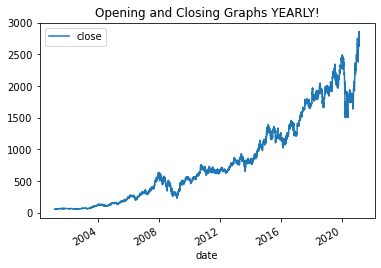

In [15]:
# Let's see the Opening and Closing graphs
main_data.set_index('date').loc[:,['close']].plot();
plt.title('Opening and Closing Graphs YEARLY!');

In [16]:
main_data = main_data.set_index('date')
main_data.sort_index(inplace=True)
main_data.head(10)

,close
date,
2001-02-27,59.13
2001-02-28,59.35
2001-03-01,59.85
2001-03-02,55.61
2001-03-05,52.62
2001-03-07,54.41
2001-03-08,54.08
2001-03-09,54.04
2001-03-12,54.51


Additive Model


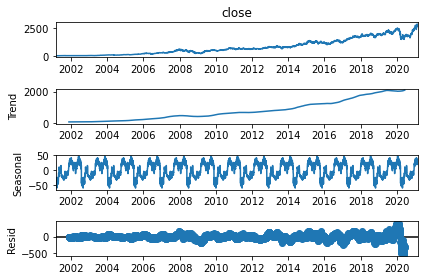

Multiplicative model


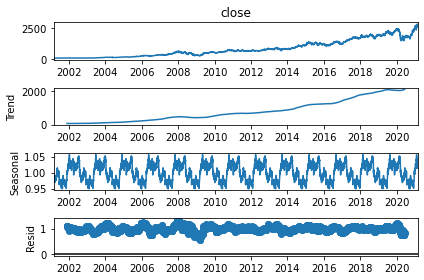

In [17]:
# so, now let's try to see the Seasonality Decompose 

series = main_data['close']
result_additive = seasonal_decompose(series, model='additive', period=365)
print('Additive Model')
#print(result_additive.seasonal)
result_additive.plot()
plt.show()

result_multiplicative = seasonal_decompose(series, model='multiplicative',period=365)
print('Multiplicative model')
#print(result_multiplicative.seasonal)
result_multiplicative.plot()
plt.show()

In [18]:
# Similar seasonality in both the plots
main_data['seasonality'] = result_additive.seasonal.values
main_data.head()

,close,seasonality
date,,
2001-02-27,59.13,-48.039387
2001-02-28,59.35,-42.685809
2001-03-01,59.85,-46.381292
2001-03-02,55.61,-53.781596
2001-03-05,52.62,-53.238746


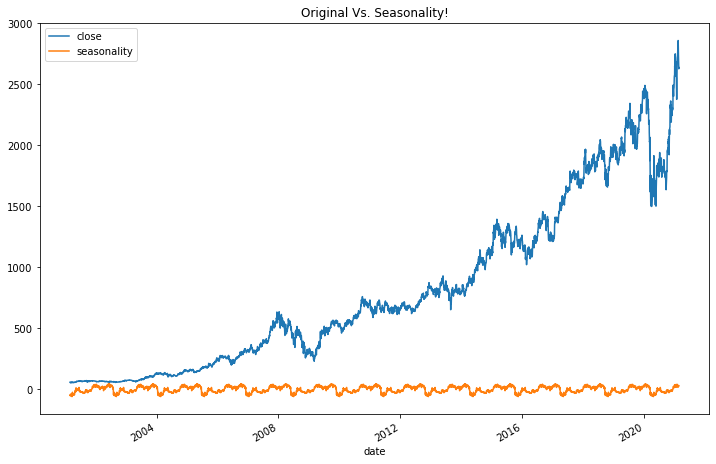

In [19]:
# let's try to see if seasonality is coping up with original series or not
main_data.plot(figsize=(12,8));
plt.title('Original Vs. Seasonality!');

In [20]:
adf_test = ts.adfuller(series, autolag='AIC')

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test[1] > 0.05:
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
    print('You can try DIFFERENCING/SMOOTHENING')
else:
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

ADF Statistic: 0.435497
p-value: 0.982775
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
You can try DIFFERENCING/SMOOTHENING


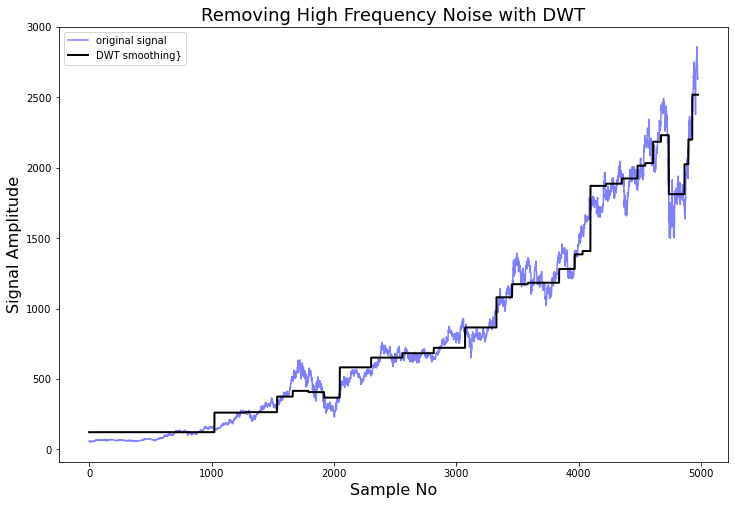

In [21]:
signal = main_data['close'].values

def lowpassfilter(signal, thresh = 0.63, wavelet="haar"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per")
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per")
    return reconstructed_signal
 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(signal, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(signal, 0.3)
ax.plot(rec, 'k', label='DWT smoothing}', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

In [22]:
dwt_df = pd.DataFrame(rec).rename(columns = {0:'dwt_values'})

In [23]:
main_data = main_data.reset_index()
final_df = pd.merge(main_data,dwt_df,how = 'inner',left_index=True,right_index=True)
final_df.head()

,date,close,seasonality,dwt_values
0,2001-02-27,59.13,-48.039387,122.642333
1,2001-02-28,59.35,-42.685809,122.642333
2,2001-03-01,59.85,-46.381292,122.642333
3,2001-03-02,55.61,-53.781596,122.642333
4,2001-03-05,52.62,-53.238746,122.642333


In [24]:
print('Shape is',final_df.shape)
print()
print('Null Value Scenario?')
print(final_df.isnull().sum())

Shape is (4973, 4)

Null Value Scenario?
date           0
close          0
seasonality    0
dwt_values     0
dtype: int64


Additive Model


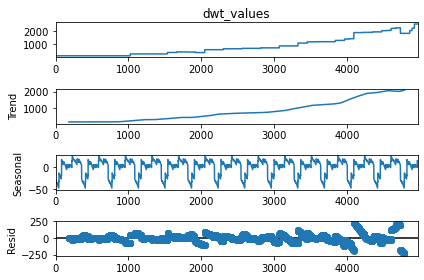

Multiplicative model


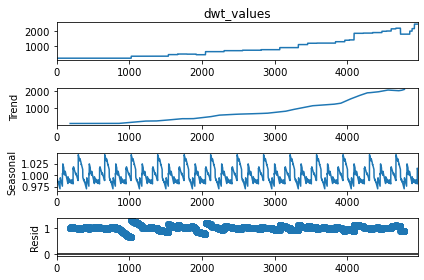

In [25]:
# so, now let's try to see the Seasonality Decompose 

series = final_df['dwt_values']
result_additive = seasonal_decompose(series, model='additive', period=365)
print('Additive Model')
#print(result_additive.seasonal)
result_additive.plot()
plt.show()

result_multiplicative = seasonal_decompose(series, model='multiplicative',period=365)
print('Multiplicative model')
#print(result_multiplicative.seasonal)
result_multiplicative.plot()
plt.show()

In [26]:
adf_test = ts.adfuller(series, autolag='AIC')

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test[1] > 0.05:
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
    print('You can try DIFFERENCING/SMOOTHENING')
else:
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

ADF Statistic: 1.229157
p-value: 0.996181
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
You can try DIFFERENCING/SMOOTHENING


In [27]:
main_data.head()

,date,close,seasonality
0,2001-02-27,59.13,-48.039387
1,2001-02-28,59.35,-42.685809
2,2001-03-01,59.85,-46.381292
3,2001-03-02,55.61,-53.781596
4,2001-03-05,52.62,-53.238746


In [28]:
from pywt import wavedec
coeffs = wavedec(main_data['close'].values.tolist(), 'haar', level=3, mode = 'smooth')
cA3, cD3, cD2, cD1 = coeffs

In [29]:
type(coeffs)

list

In [30]:
print('cA3',len(cA3))
print('cD3',len(cD3))
print('cD2',len(cD2))
print('cD1',len(cD1))

cA3 622
cD3 622
cD2 1244
cD1 2487


In [31]:
final_df.head()

,date,close,seasonality,dwt_values
0,2001-02-27,59.13,-48.039387,122.642333
1,2001-02-28,59.35,-42.685809,122.642333
2,2001-03-01,59.85,-46.381292,122.642333
3,2001-03-02,55.61,-53.781596,122.642333
4,2001-03-05,52.62,-53.238746,122.642333


In [32]:
final_df['cA3'] = 0
final_df['cD3'] = 0
final_df['cD2'] = 0
final_df['cD1'] = 0

In [33]:
final_df.head()

,date,close,seasonality,dwt_values,cA3,cD3,cD2,cD1
0,2001-02-27,59.13,-48.039387,122.642333,0,0,0,0
1,2001-02-28,59.35,-42.685809,122.642333,0,0,0,0
2,2001-03-01,59.85,-46.381292,122.642333,0,0,0,0
3,2001-03-02,55.61,-53.781596,122.642333,0,0,0,0
4,2001-03-05,52.62,-53.238746,122.642333,0,0,0,0


In [34]:
final_df.iloc[int((len(final_df)-len(cA3))/2)+1:-int((len(final_df)-len(cA3))/2),4]= cA3
final_df.iloc[int((len(final_df)-len(cD3))/2)+1:-int((len(final_df)-len(cD3))/2),5]= cD3
final_df.iloc[int((len(final_df)-len(cD2))/2)+1:-int((len(final_df)-len(cD2))/2),6]= cD2
final_df.iloc[int((len(final_df)-len(cD1))/2)+1:-int((len(final_df)-len(cD1))/2)+1,7]= cD1

In [35]:
final_df.iloc[int((len(final_df)-len(cA3))/2)+1:-int((len(final_df)-len(cA3))/2),4].shape

(622,)

In [36]:
final_df.iloc[int((len(final_df)-len(cD3))/2)+1:-int((len(final_df)-len(cD3))/2),5].shape

(622,)

In [37]:
final_df.iloc[int((len(final_df)-len(cD2))/2)+1:-int((len(final_df)-len(cD2))/2),6].shape

(1244,)

In [38]:
final_df.iloc[int((len(final_df)-len(cD1))/2)+1:-int((len(final_df)-len(cD1))/2)+1,7].shape

(2487,)

In [39]:
pd.set_option('display.max_rows', final_df.shape[0]+1)
final_df


,date,close,seasonality,dwt_values,cA3,cD3,cD2,cD1
0,2001-02-27,59.13,-48.039387,122.642333,0.000000,0.000000,0.000000e+00,0.000000
1,2001-02-28,59.35,-42.685809,122.642333,0.000000,0.000000,0.000000e+00,0.000000
2,2001-03-01,59.85,-46.381292,122.642333,0.000000,0.000000,0.000000e+00,0.000000
3,2001-03-02,55.61,-53.781596,122.642333,0.000000,0.000000,0.000000e+00,0.000000
4,2001-03-05,52.62,-53.238746,122.642333,0.000000,0.000000,0.000000e+00,0.000000
5,2001-03-07,54.41,-49.539476,122.642333,0.000000,0.000000,0.000000e+00,0.000000
6,2001-03-08,54.08,-38.232555,122.642333,0.000000,0.000000,0.000000e+00,0.000000
7,2001-03-09,54.04,-41.150270,122.642333,0.000000,0.000000,0.000000e+00,0.000000
8,2001-03-12,54.51,-50.537149,122.642333,0.000000,0.000000,0.000000e+00,0.000000
9,2001-03-13,54.60,-54.018426,122.642333,0.000000,0.000000,0.000000e+00,0.000000


Verification

In [40]:
n = len(final_df)
my = pywt.upcoef('a', final_df.cA3.to_numpy(), 'haar', level = 3,take=n) + pywt.upcoef('d', final_df.cD3.to_numpy(), 'haar', level = 3,take=n)+ pywt.upcoef('d', final_df.cD2.to_numpy(), 'haar', level = 3,take=n)+ pywt.upcoef('d', final_df.cD1.to_numpy(), 'haar',level = 3, take=n)

In [41]:
my

array([   7.76856385,    7.76856385,    7.76856385, ..., 2823.27874279,
       2701.44175234, 2701.44175234])

In [42]:
len(my)

4973

In [43]:
final_df['upcowef'] = my

In [44]:
final_df.head()

,date,close,seasonality,dwt_values,cA3,cD3,cD2,cD1,upcowef
0,2001-02-27,59.13,-48.039387,122.642333,0.0,0.0,0.0,0.0,7.768564
1,2001-02-28,59.35,-42.685809,122.642333,0.0,0.0,0.0,0.0,7.768564
2,2001-03-01,59.85,-46.381292,122.642333,0.0,0.0,0.0,0.0,7.768564
3,2001-03-02,55.61,-53.781596,122.642333,0.0,0.0,0.0,0.0,54.519628
4,2001-03-05,52.62,-53.238746,122.642333,0.0,0.0,0.0,0.0,54.519628


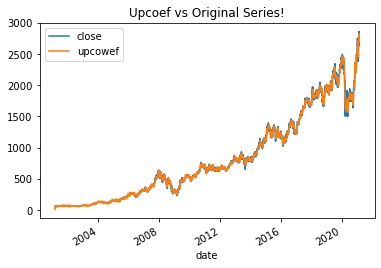

In [45]:
final_df.set_index('date').loc[:,['close','upcowef']].plot();
plt.title('Upcoef vs Original Series!');

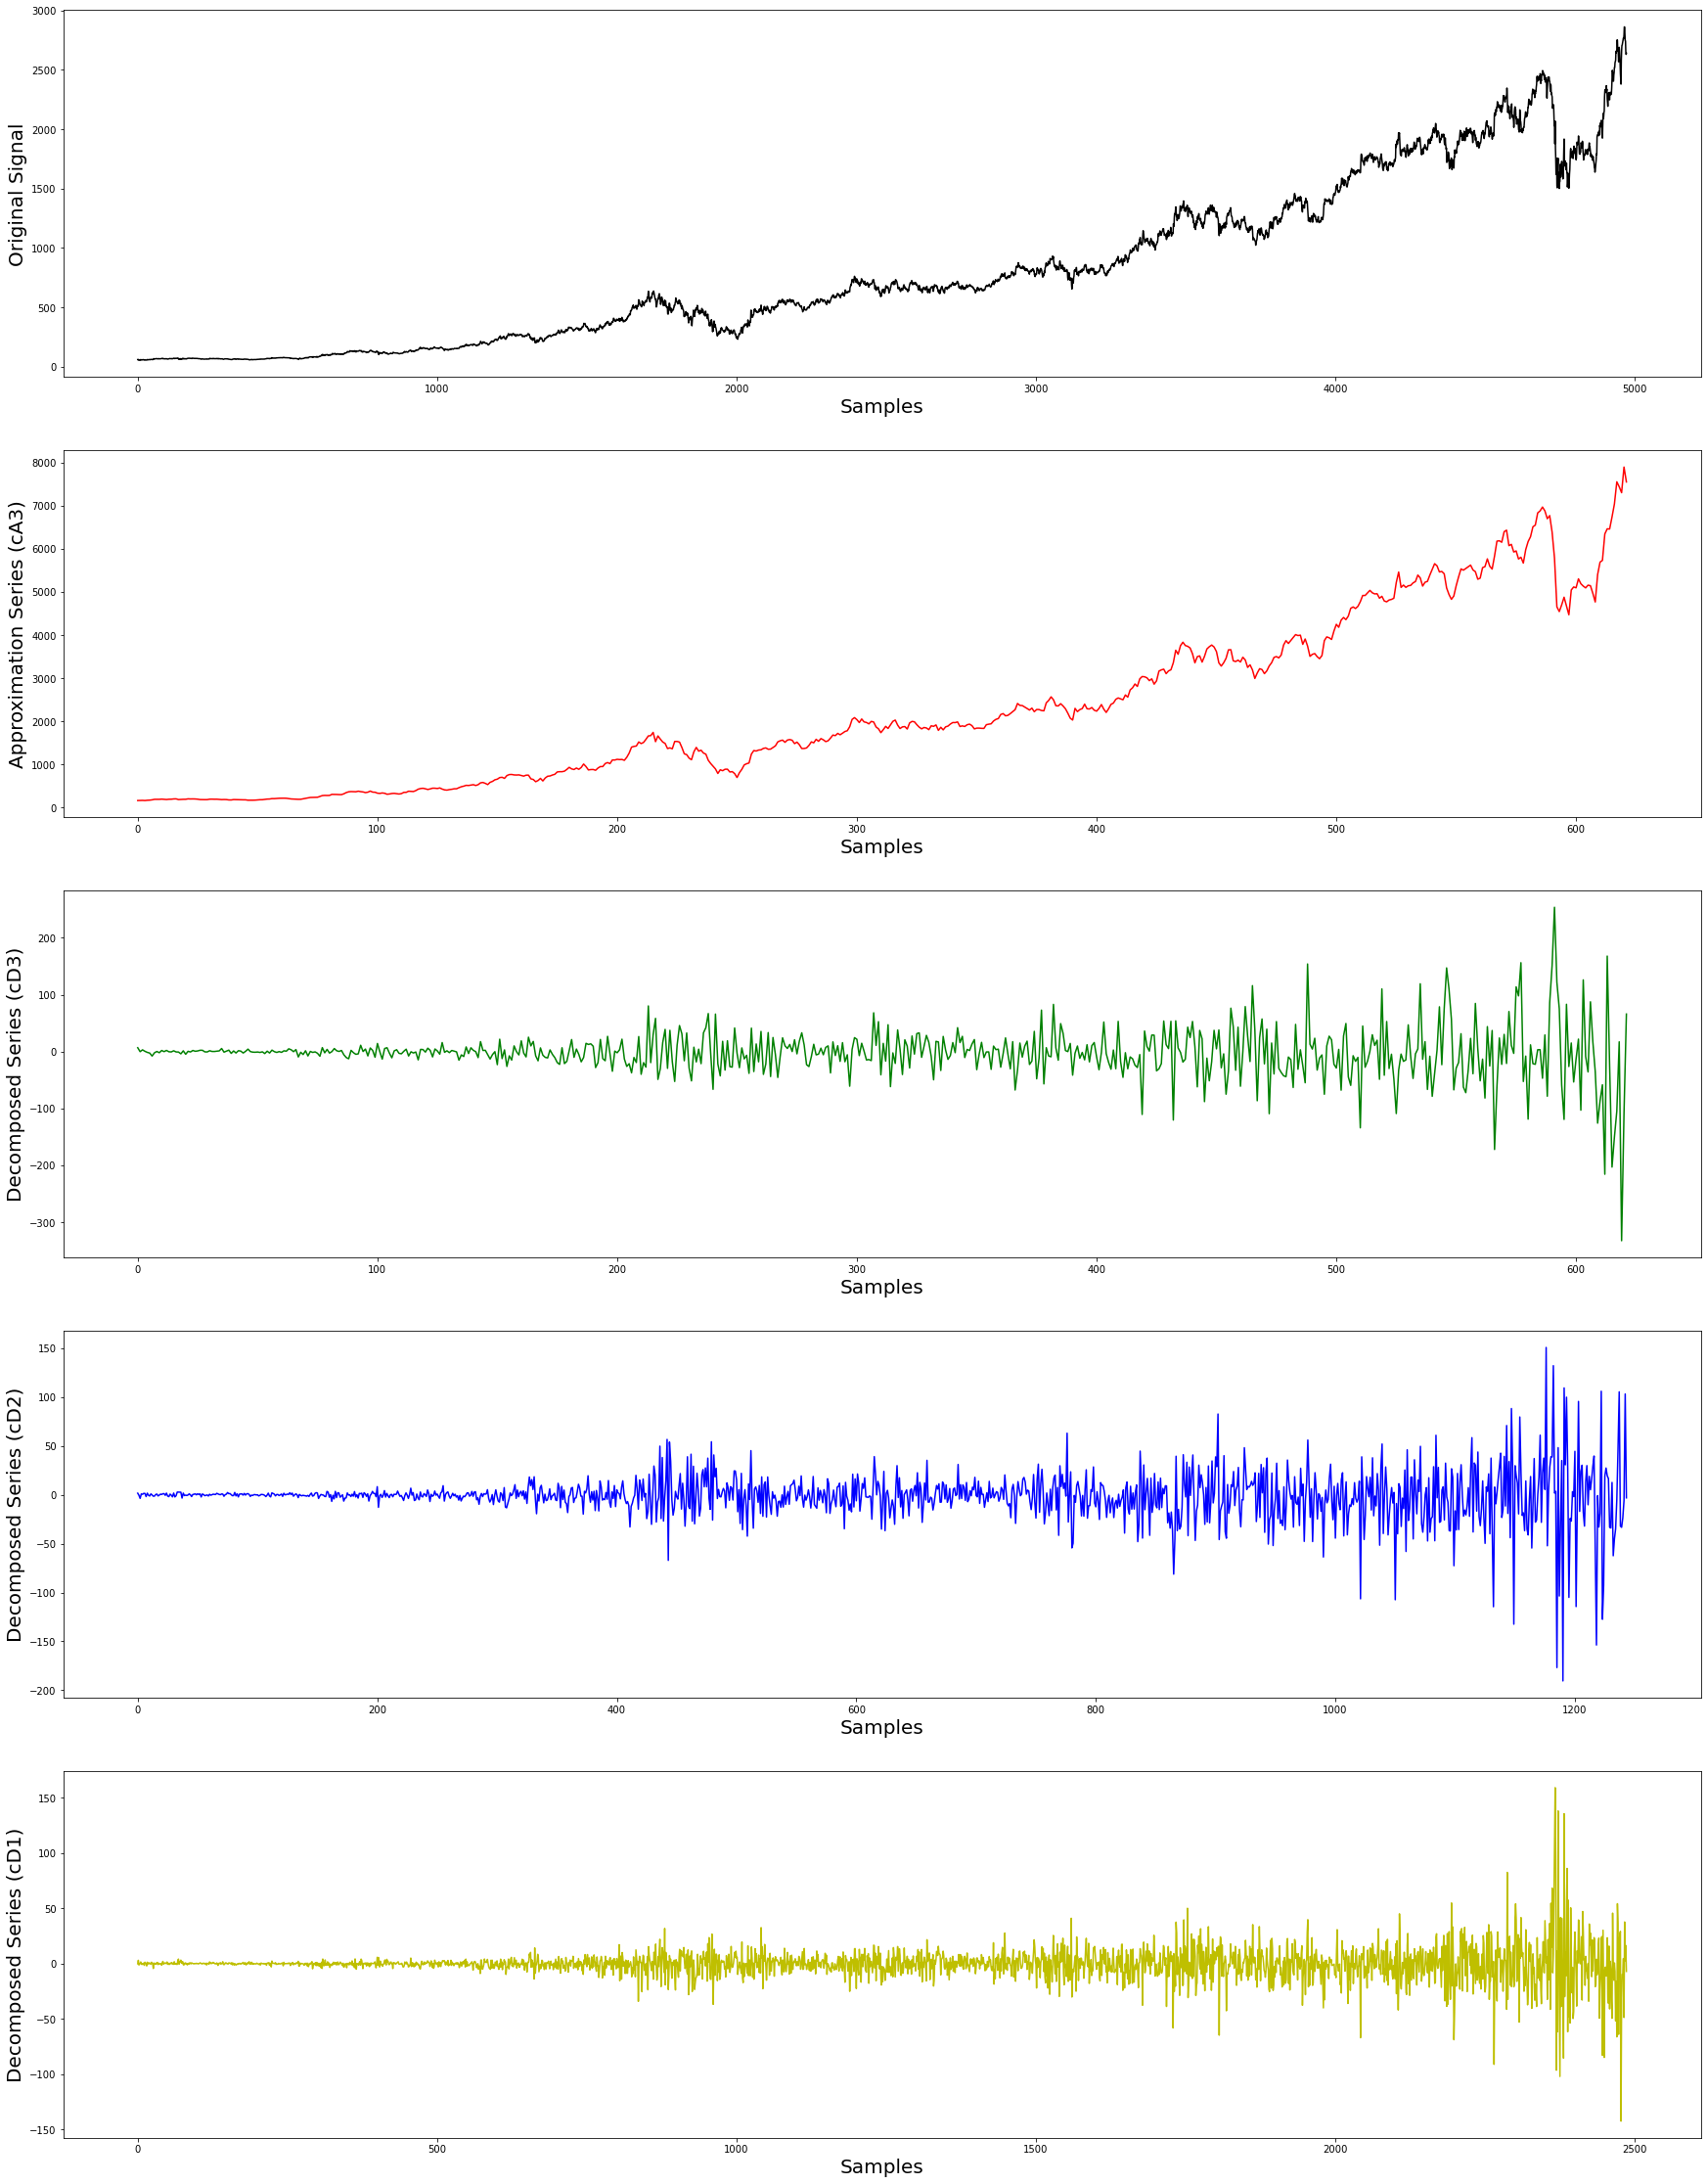

In [46]:
L = len(main_data['close'])
y = coeffs[0:L]
plt.figure(figsize = (30,40))
plt.subplot(5,1,1)
plt.plot(main_data['close'],color = 'k');
plt.xlabel('Samples', fontsize=20);
plt.ylabel('Original Signal', fontsize=20);

plt.subplot(5,1,2)
plt.plot(cA3,color = 'r');
plt.xlabel('Samples', fontsize=20);
plt.ylabel('Approximation Series (cA3)', fontsize=20);

plt.subplot(5,1,3)
plt.plot(cD3,color = 'g');
plt.xlabel('Samples', fontsize=20);
plt.ylabel('Decomposed Series (cD3)', fontsize=20);

plt.subplot(5,1,4)
plt.plot(cD2,color = 'b');
plt.xlabel('Samples', fontsize=20);
plt.ylabel('Decomposed Series (cD2)', fontsize=20);

plt.subplot(5,1,5)
plt.plot(cD1,color = 'y');
plt.xlabel('Samples', fontsize=20);
plt.ylabel('Decomposed Series (cD1)', fontsize=20);
